# Convergence

stationary action, hamiltonian, wave function

Trend framework “build order” (fast path)

Multi-horizon trend signals (risk-scaled, squashed)

Portfolio vol targeting + leverage caps

Simple cost model + turnover penalty

Robust covariance (shrinkage EWMA)

Online expert weighting (after costs)

Drawdown governor + regime conditioning


Factor model + residuals

Cross-sectional residual mean reversion alpha

Neutrality constraints + risk model sizing

Transaction cost model + turnover penalty

Clustering + within-cluster relative value

Kalman pairs/baskets overlay

Execution simulator (spread/impact/participation)

In [1]:
import ccxt
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timezone
import matplotlib.pyplot as plt

In [173]:
def rolling_linreg_slope(y: pd.Series, window: int = 20) -> pd.Series:
    """
    Rolling OLS slope of y ~ a + b*x over a window, where x = 0..window-1.
    Returns slope per bar.
    """
    y = y.astype(float)
    x = np.arange(window, dtype=float)

    x_mean = x.mean()
    x_demean = x - x_mean
    denom = np.sum(x_demean**2)  # constant for a fixed window

    def slope_last_window(y_window: np.ndarray) -> float:
        y_demean = y_window - y_window.mean()
        return float(np.dot(x_demean, y_demean) / denom)

    return y.rolling(window, min_periods=window).apply(slope_last_window, raw=True)


import numpy as np

def rolling_ols_intercept_slope_segment(y, window: int):
    """
    Rolling OLS of y ~ (alpha + beta * x), where x = 0..window-1 inside each window.
    Returns alpha, beta arrays of same length as y, padded with NaN for the first window-1 points.
    """
    y = np.asarray(y, dtype=float)
    n = int(window)
    if n < 2:
        raise ValueError("window must be >= 2")
    if y.size < n:
        # not enough data in this segment
        return np.full_like(y, np.nan), np.full_like(y, np.nan)

    x = np.arange(n, dtype=float)
    sum_x = x.sum()
    sum_x2 = (x * x).sum()
    denom = n * sum_x2 - sum_x**2
    if denom == 0:
        raise ValueError("degenerate window; denom=0")

    ones = np.ones(n, dtype=float)

    # rolling sums for each window (valid positions only)
    sum_y  = np.convolve(y, ones, mode="valid")   # length = len(y)-n+1
    sum_xy = np.convolve(y, x,    mode="valid")   # x-weighted sum in each window

    beta  = (n * sum_xy - sum_x * sum_y) / denom
    alpha = (sum_y - beta * sum_x) / n

    # pad to match original length
    pad = np.full(n - 1, np.nan)
    alpha_full = np.concatenate([pad, alpha])
    beta_full  = np.concatenate([pad, beta])
    return alpha_full, beta_full


## Data

### DAL

In [147]:
dal_df = yf.download("JPM", start="2000-01-01", end="2025-01-01")
dal_1m_df = yf.download("JPM", interval="1m", period="7d")

dal_df.columns = dal_df.columns.droplevel(1)
dal_df = dal_df.reset_index(drop = True)

C:\Users\Mark Brezina\AppData\Local\Temp\ipykernel_10956\2688795552.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dal_df = yf.download("JPM", start="2000-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed
C:\Users\Mark Brezina\AppData\Local\Temp\ipykernel_10956\2688795552.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dal_1m_df = yf.download("JPM", interval="1m", period="7d")
[*********************100%***********************]  1 of 1 completed


### BTC

In [3]:
EXCHANGE_MAP = {
    "binance": ccxt.binance,
    "kraken": ccxt.kraken,
    "gemini": ccxt.gemini,
    "coinbase": ccxt.coinbase,  # ccxt "coinbase" is Coinbase Exchange (Advanced Trade)
}

def get_exchange(name: str):
    name = name.lower().strip()
    if name not in EXCHANGE_MAP:
        raise ValueError(f"Unknown exchange '{name}'. Choose: {list(EXCHANGE_MAP.keys())}")
    ex = EXCHANGE_MAP[name]({"enableRateLimit": True})
    ex.load_markets()
    return ex

def fetch_ohlcv_history(exchange_name: str, symbol: str, timeframe: str, since_iso: str, max_bars: int = 10000):
    ex = get_exchange(exchange_name)
    since_ms = ex.parse8601(since_iso)

    all_rows = []
    while len(all_rows) < max_bars:
        batch = ex.fetch_ohlcv(symbol, timeframe=timeframe, since=since_ms, limit=1000)
        if not batch:
            break
        all_rows.extend(batch)
        since_ms = batch[-1][0] + 1  # move forward 1ms to avoid duplicates

        # safety: stop if exchange keeps returning same last timestamp
        if len(batch) < 2:
            break

    df = pd.DataFrame(all_rows, columns=["timestamp_ms","open","high","low","close","volume"])
    df["timestamp"] = pd.to_datetime(df["timestamp_ms"], unit="ms", utc=True)
    df = df.drop(columns=["timestamp_ms"]).drop_duplicates(subset=["timestamp"]).sort_values("timestamp")
    return df[["timestamp","open","high","low","close","volume"]]


def fetch_spot_price(exchange_name: str, symbol: str):
    ex = get_exchange(exchange_name)
    t = ex.fetch_ticker(symbol)
    # ticker fields vary a bit; 'last' is usually the spot last traded price
    return {
        "exchange": exchange_name,
        "symbol": symbol,
        "timestamp": datetime.fromtimestamp(t["timestamp"]/1000, tz=timezone.utc) if t.get("timestamp") else None,
        "last": t.get("last"),
        "bid": t.get("bid"),
        "ask": t.get("ask"),
        "quoteVolume": t.get("quoteVolume"),
    }

def fetch_ohlcv(exchange_name: str, symbol: str, timeframe: str = "1h", limit: int = 500):
    """
    Returns a DataFrame with columns: timestamp, open, high, low, close, volume (UTC)
    """
    ex = get_exchange(exchange_name)

    # Some exchanges use different symbol formats. We'll check it's listed.
    if symbol not in ex.markets:
        # quick heuristic alternatives
        raise ValueError(
            f"Symbol '{symbol}' not found on {exchange_name}. "
            f"Try exchange-specific formats (e.g. Kraken: 'BTC/USD' or 'XBT/USD')."
        )

    ohlcv = ex.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit)
    df = pd.DataFrame(ohlcv, columns=["timestamp_ms", "open", "high", "low", "close", "volume"])
    df["timestamp"] = pd.to_datetime(df["timestamp_ms"], unit="ms", utc=True)
    df = df.drop(columns=["timestamp_ms"])
    return df[["timestamp", "open", "high", "low", "close", "volume"]]


In [345]:
btc_df = yf.download("BTC-USD", start="2000-01-01", end="2026-01-01")
btc_1m_df = fetch_ohlcv_history(exchange_name = "coinbase", symbol = "BTC/USD", timeframe = "1m", since_iso = "2025-01-22T00:00:00Z", max_bars = 10000)
btc_df.columns = btc_df.columns.droplevel(1)
btc_df = btc_df.reset_index(drop = True)

C:\Users\Mark Brezina\AppData\Local\Temp\ipykernel_15924\703298346.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc_df = yf.download("BTC-USD", start="2000-01-01", end="2026-01-01")
[*********************100%***********************]  1 of 1 completed


## Analytics

### DAL

In [149]:
dal_df["log_p"] = np.log(dal_df["Close"])
dal_df["Returns"] = (dal_df['Close'] / dal_df['Close'].shift(1)) - 1
dal_df = dal_df.reset_index(drop = True)

mmx = [1]
mmx_idx = [1]

mmn = [0]
mmn_idx = [0]
for i in range(1,len(dal_df)):
    mmx.append(max(dal_df["Close"][0:i]))
    mmn.append(min(dal_df["Close"][0:i]))
    
    if dal_df["Close"][i] == max(dal_df["Close"][0:i]):
        mmx_idx.append(i)
    elif dal_df["Close"][i] == min(dal_df["Close"][0:i]):
        mmn_idx.append(i)


In [347]:
import numpy as np

close = dal_df["Close"].to_numpy()
idx   = dal_df.index

t_max = 0
current_max = close[0]

tms_pos = [0]
tms_ts  = [idx[0]]

for i in range(2, len(close)):
    # candidate peak is at i-1 if price drops at i
    if close[i-1] > current_max and close[i] <= close[i-1]:
        current_max = close[i-1]
        t_max = i-1                    # <-- FIXED (was i)
        tms_pos.append(t_max)
        tms_ts.append(idx[t_max])

tms_pos_set = set(tms_pos)
logp = dal_df["log_p"].to_numpy()

def slope_last(y):
    """OLS slope of y ~ a + b*x where x = 0..n-1"""
    n = len(y)
    if n < 2:
        return np.nan
    x = np.arange(n, dtype=float)
    b = np.cov(x, y, bias=True)[0, 1] / np.var(x)
    return b

w = 200          # choose a window cap inside each segment (optional)
min_len = 10     # don’t fit slopes on tiny segments

alp = np.full(len(dal_df), np.nan, dtype=float)

last_peak = 0
for i in range(len(dal_df)):
    if i in tms_pos_set and i != 0:
        last_peak = i

    seg_start = last_peak
    seg = logp[seg_start:i+1]

    # optional: only use last w points within the segment
    if len(seg) > w:
        seg = seg[-w:]

    if len(seg) >= min_len:
        alp[i] = slope_last(seg)
    else:
        alp[i] = 0.0  # or np.nan

dal_df["seg_slope"] = alp


In [290]:
linreg_alpha = [0,0]
linreg_beta = [0,0]

for i in range(3, len(dal_df)):
    alpha, beta= rolling_ols_intercept_slope(dal_df["Close"][0:i], window=i)
    linreg_alpha.append(alpha[i-1])
    linreg_beta.append(beta[i-1] )

linreg_alpha = linreg_alpha[10:]

linreg_beta = linreg_beta[10:]

In [345]:
alp = pd.DataFrame(alp)

(-0.0015, 0.005)

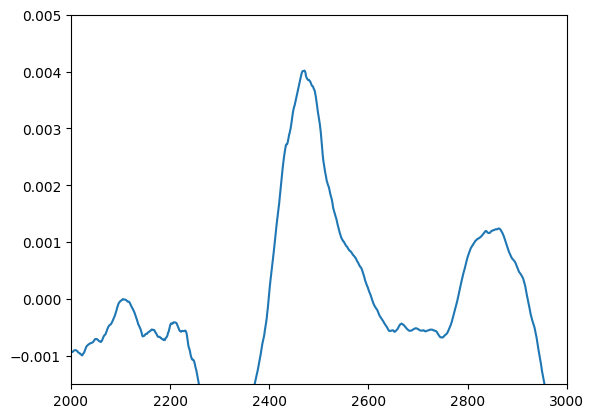

In [355]:
alpha, beta = rolling_ols_intercept_slope(dal_df["log_p"][0:3900], window=700)
#test = []
#test = pd.DataFrame(test)
#test2 = dal_df["Close"][3200:3900] / max(dal_df["Close"][3200:3900])
#test2 = test2.reset_index(drop = True) 
plt.plot(alp)
plt.xlim(2000,3000)
plt.ylim(-0.0015,0.005)
#plt.plot((dal_df["Close"][4600:5500] - 120)/6000)
#plt.plot(test2)

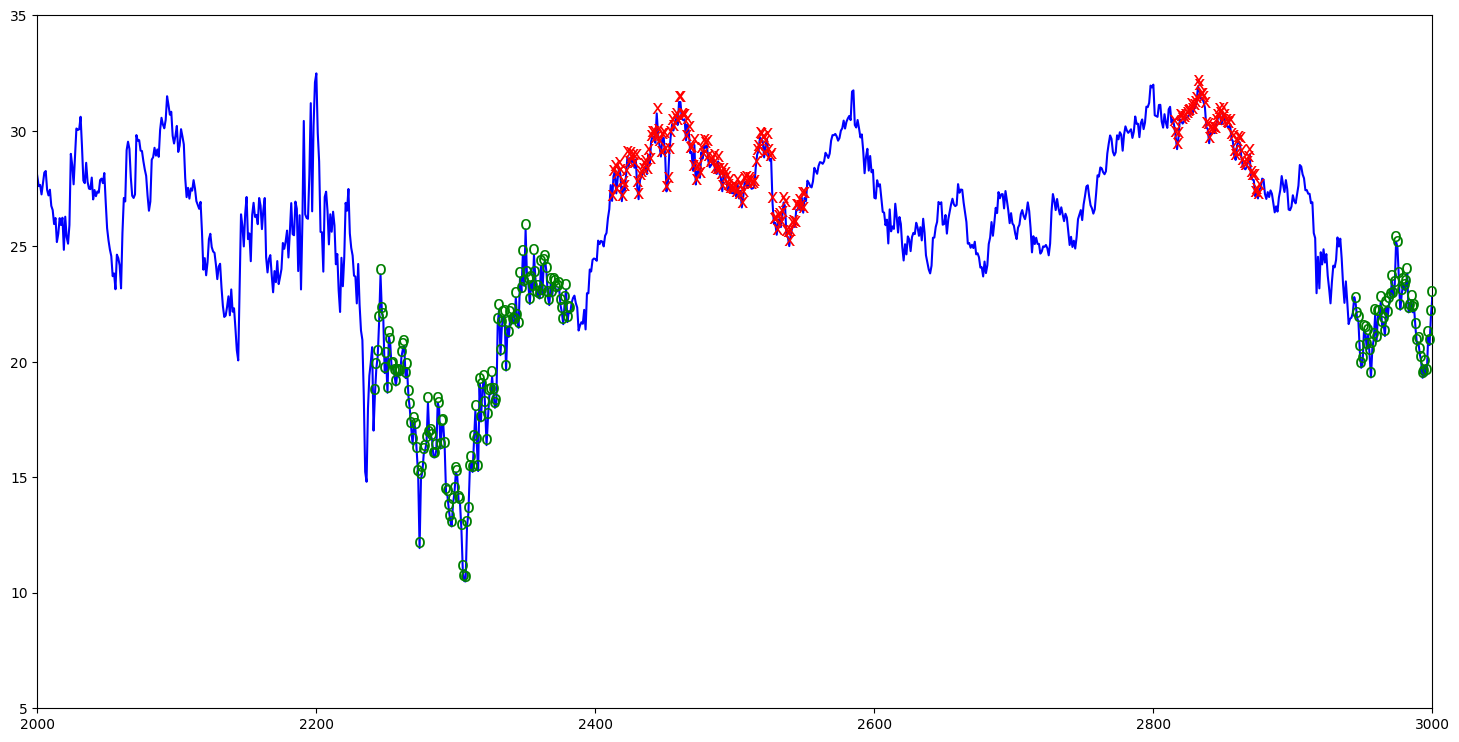

In [364]:
# 1. cutting points.
# 2. turning points.
dal_df['long_signal'] = False
dal_df['long_signal'] = (alp < -0.001)
# Generate short (sell) signals
dal_df['short_signal'] = False
dal_df['short_signal'] = (alp > 0.001)              #(dal_df["MA21D"] > 0.05) & (abs(dal_df["U"]) > 0) 

fig, ax = plt.subplots(figsize=(18, 9)) 

# Add arrows for long (buy) signals
long_signal_dates = dal_df[dal_df['long_signal']].index
for date in long_signal_dates:
    ax.annotate('o', xy=(date, dal_df.loc[date, 'Close']), color='green', fontsize=14, ha='center')

# Add arrows for short (sell) signals
short_signal_dates = dal_df[dal_df['short_signal']].index
for date in short_signal_dates:
    ax.annotate('x', xy=(date, dal_df.loc[date, 'Close']), color='red', fontsize=14, ha='center')

plt.plot(dal_df["Close"], color = "blue")

plt.xlim(2000,3000)
plt.ylim(5,35)
plt.show()

In [4]:
dal_df.columns = dal_df.columns.droplevel(1)
dal_df["log_p"] = np.log(dal_df["Close"])
dal_df["Returns"] = (dal_df['Close'] / dal_df['Close'].shift(1)) - 1

# Moving averages
dal_df['MA6'] = dal_df['log_p'].rolling(window=6).mean()
dal_df['MA21'] = dal_df['log_p'].rolling(window=21).mean()
dal_df['MA40'] = dal_df['log_p'].rolling(window=40).mean()

# Moving averages
dal_df['MA6D'] = np.exp(dal_df["log_p"] - dal_df["MA6"]) - 1
dal_df['MA21D'] = np.exp(dal_df["log_p"] - dal_df["MA21"]) - 1
dal_df['MA40D'] = np.exp(dal_df["log_p"] - dal_df["MA40"]) - 1

# Potential energy
dal_df["m"] = dal_df["log_p"].ewm(span=21, adjust=False).mean()
dal_df["s"] = dal_df['log_p'].ewm(span=21, adjust=False).std()
dal_df["U"] = (dal_df["log_p"] - dal_df["m"]) / (dal_df["s"])

# Intraday range
tr = [0]
for i in range(1,len(dal_df)):
    tr1 = (dal_df.High.iloc[i] - dal_df.Low.iloc[i]) / dal_df.Low.iloc[i] 
    tr2 = abs(dal_df.High.iloc[i] - dal_df.Close.iloc[i-1]) / dal_df.Close.iloc[i-1]
    tr3 = abs(dal_df.Low.iloc[i] - dal_df.Close.iloc[i-1]) / dal_df.Close.iloc[i-1]

    
    tr.append(max(tr1,tr2,tr3))

dal_df["TR"] = tr
dal_df["ATR"] = dal_df["TR"].rolling(window=21).mean()
dal_df["DATR"] = (dal_df['ATR'] / dal_df['ATR'].shift(1)) - 1
dal_df["D2ATR"] = dal_df["DATR"].rolling(window=21).mean()
dal_df = dal_df.reset_index(drop = True)

dal_df = dal_df.reset_index(drop = True)

In [5]:
def rolling_ols_intercept_slope(y: pd.Series, window: int):
    """
    Rolling OLS for y = alpha + beta * t  (t is global index: 0..n-1)
    Returns alpha_t, beta_t aligned with y (NaN until window-1).
    """
    y = y.astype(float)
    n = len(y)
    t = np.arange(n, dtype=float)

    # rolling means
    y_bar = y.rolling(window).mean()
    t_bar = pd.Series(t, index=y.index).rolling(window).mean()

    # rolling cov(t,y) and var(t)
    ty_bar = (y * t).rolling(window).mean()
    t2_bar = pd.Series(t*t, index=y.index).rolling(window).mean()

    cov_ty = ty_bar - t_bar * y_bar
    var_t  = t2_bar - t_bar * t_bar

    beta = cov_ty / var_t
    alpha = y_bar - beta * t_bar

    return alpha, beta

In [8]:
dal_df["log_p"] = np.log(dal_df["Close"])
linreg_alpha = [0,0]
linreg_beta = [0,0]

loglinreg_alpha = [0,0]
loglinreg_beta = [0,0]
for i in range(3, len(dal_df)):
    w = min(i-1,200)
    alpha, beta= rolling_ols_intercept_slope(dal_df["Close"][0:i], window=w)
    linreg_alpha.append(alpha[i-1])
    linreg_beta.append(beta[i-1] )
    
    alpha, beta = rolling_ols_intercept_slope(dal_df["log_p"][0:i], window=w)
    loglinreg_alpha.append(alpha[i-1])
    loglinreg_beta.append(beta[i-1])

linreg_alpha = linreg_alpha[10:]
linreg_beta = linreg_beta[10:]
loglinreg_alpha = loglinreg_alpha[10:]
loglinreg_beta = loglinreg_beta[10:]

r = dal_df.log_p[11:]-(loglinreg_beta*dal_df.index[11:]+loglinreg_alpha)
r_m = r.rolling(window=20).mean()
r_s = r.rolling(window=20).std()
z = (r-r_m)/r_s

dal_df["z"] = z
dal_df["z"] = dal_df["z"].fillna(0)

dal_df["TS"] = (dal_df["log_p"].ewm(span=21, adjust=False).mean() - dal_df["log_p"].ewm(span=40, adjust=False).mean()) / dal_df["log_p"].rolling(window=21).std()

dal_df["TSM"] = dal_df["log_p"] / dal_df["log_p"].shift(21) - 1
dal_df['Momentum'] = dal_df["Returns"].rolling(window=21).mean()
dal_df['TSMom'] = dal_df['Returns'].rolling(window=21).mean() / dal_df["Returns"].rolling(window=21).std()
dal_df["Sih"] = np.tanh(dal_df["TS"])
dal_df["Sih2"] = np.tanh(dal_df["TSMom"])

dal_df["theta"] = -rolling_linreg_slope(y = dal_df["MA21D"].shift(1), window = 21)
dal_df["Kin"] = 1/2 * (dal_df['log_p'] - dal_df['log_p'].shift(1))**2
dal_df["Pot"] = 1/8 * (dal_df['log_p'] - dal_df['MA21'])**2
dal_df["lagrangian"] = dal_df["Kin"] - dal_df["Pot"]
dal_df["ent"] = dal_df["lagrangian"].rolling(window=21).sum()


In [7]:
# Price volatility
dal_df['Pvol'] = dal_df['log_p'].rolling(window=21).std()
dal_df['PEvol'] = dal_df['Close'].ewm(span=21, adjust=False).std()
# Returns and returns volatility
dal_df["Returns"] = (dal_df['Close'] / dal_df['Close'].shift(1)) - 1
dal_df['Rvol'] = dal_df['Returns'].rolling(window=21).std()
dal_df["realized_vol"] = dal_df["Rvol"] * np.sqrt(252)


dal_df['REvol'] = dal_df['Returns'].ewm(span=21, adjust=False).std()
# D1 of price-volatility
dal_df["DPvol"] = (dal_df['Pvol'] - dal_df['Pvol'].shift(1))/dal_df['Pvol'].shift(1)
# D1 of returns-volatility
dal_df["DRvol"] = (dal_df['Rvol'] - dal_df['Rvol'].shift(1))/dal_df['Rvol'].shift(1)

target_vol = 0.20  # 20% annualized target (example)
dal_df["position_adjust"] = (target_vol / dal_df["realized_vol"]).clip(0.0, 2.0)

In [138]:
a = (test - test.shift(1))
b = (test - test.shift(3))
c = (test - test.shift(5))
d = (test - test.shift(21))
e = (test - test.shift(40))
f = (test - test.shift(90))
ss = 1/6 * (a+b+c+d+e+f)
ss = ss[90:]
ss = ss.reset_index(drop = True)

In [139]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss

x = pd.Series(ss[0]).dropna().astype(float)

adf_stat, adf_p, *_ = adfuller(x, autolag="AIC")
kpss_stat, kpss_p, *_ = kpss(x, regression="c", nlags="auto")  # "c" = stationary around constant mean

print("ADF p-value:", adf_p)
print("KPSS p-value:", kpss_p)


ADF p-value: 0.00024225671967740374
KPSS p-value: 0.05167370716361739


(3200.0, 3900.0)

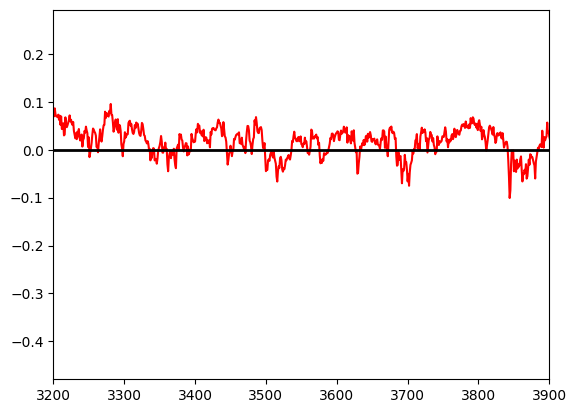

In [100]:
#plt.plot(dal_df["ent"])
#plt.plot(a, color = "blue", alpha = 0.25)
#plt.plot(b, color = "blue", alpha = 0.25)
#plt.plot(c, color = "blue", alpha = 0.25)
#plt.plot(d, color = "blue", alpha = 0.25)
plt.plot(ss, color = "red", alpha = 1)
#plt.plot(dal_df["Kin"], color = "blue")
#plt.plot(dal_df["Pot"], color = "red")
#plt.plot(dal_df["Close"])
plt.axhline(y=0 ,color = "black", linestyle="-", linewidth = 2)
plt.xlim(3200,3900)
#plt.ylim(20,55)

(10.0, 35.0)

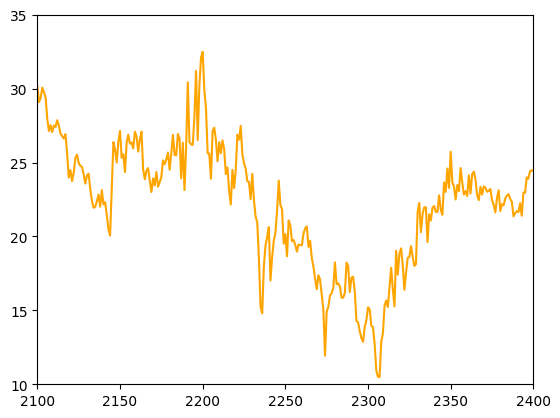

In [25]:
plt.plot(dal_df.Close, color="orange")
#plt.axhline(y=0.18, color='black', linestyle='--', linewidth=2, label='Threshold')
#plt.axhline(y=0.05, color='red', linestyle='--', linewidth=2, label='Threshold')
#plt.axhline(y=-0.05, color='red', linestyle='--', linewidth=2, label='Threshold')
#plt.axhline(y=-0.18, color='black', linestyle='--', linewidth=2, label='Threshold')
plt.xlim(2100,2400)
plt.ylim(10,35)

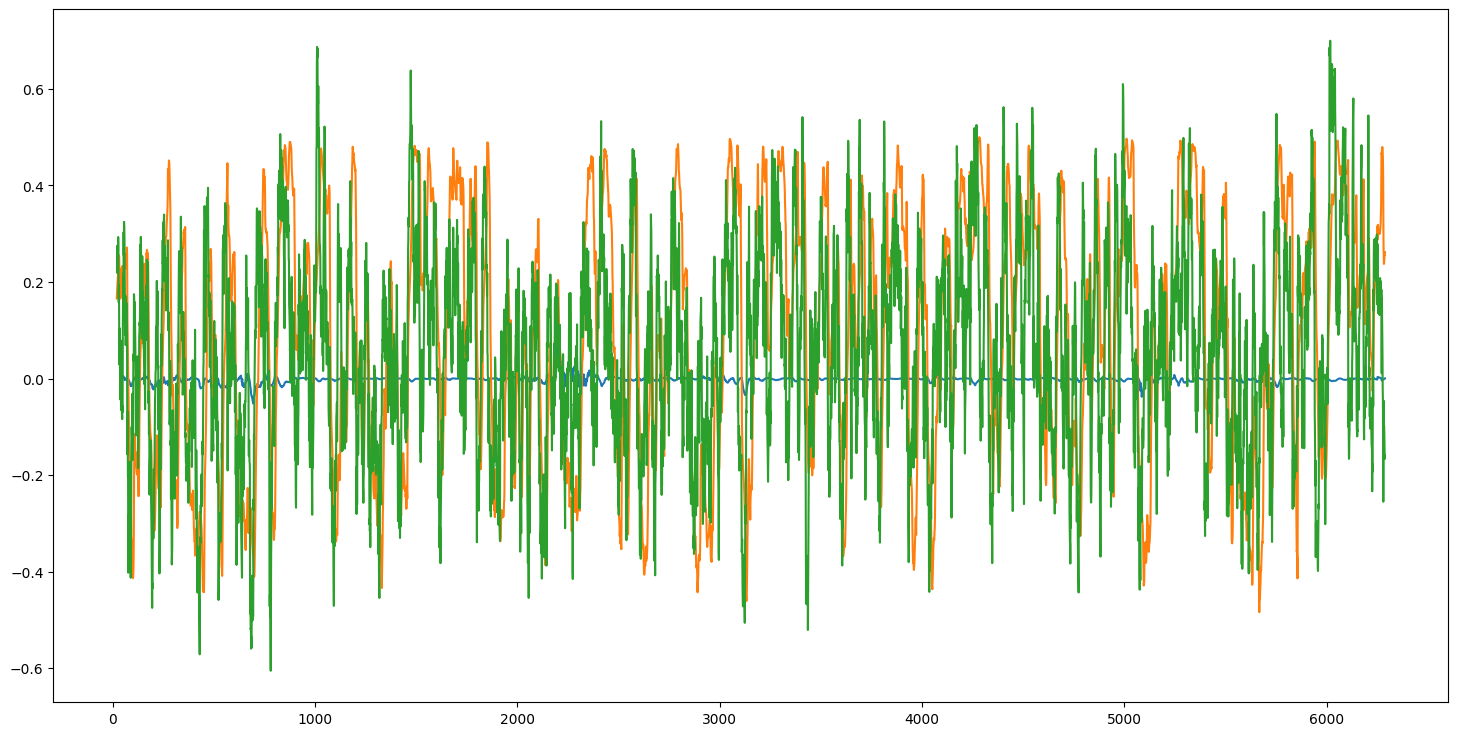

In [886]:
plt.figure(figsize=(18, 9)) 
plt.plot(dal_df["ent"])
plt.plot(dal_df["Sih"]/2)
plt.plot(dal_df["Sih2"])

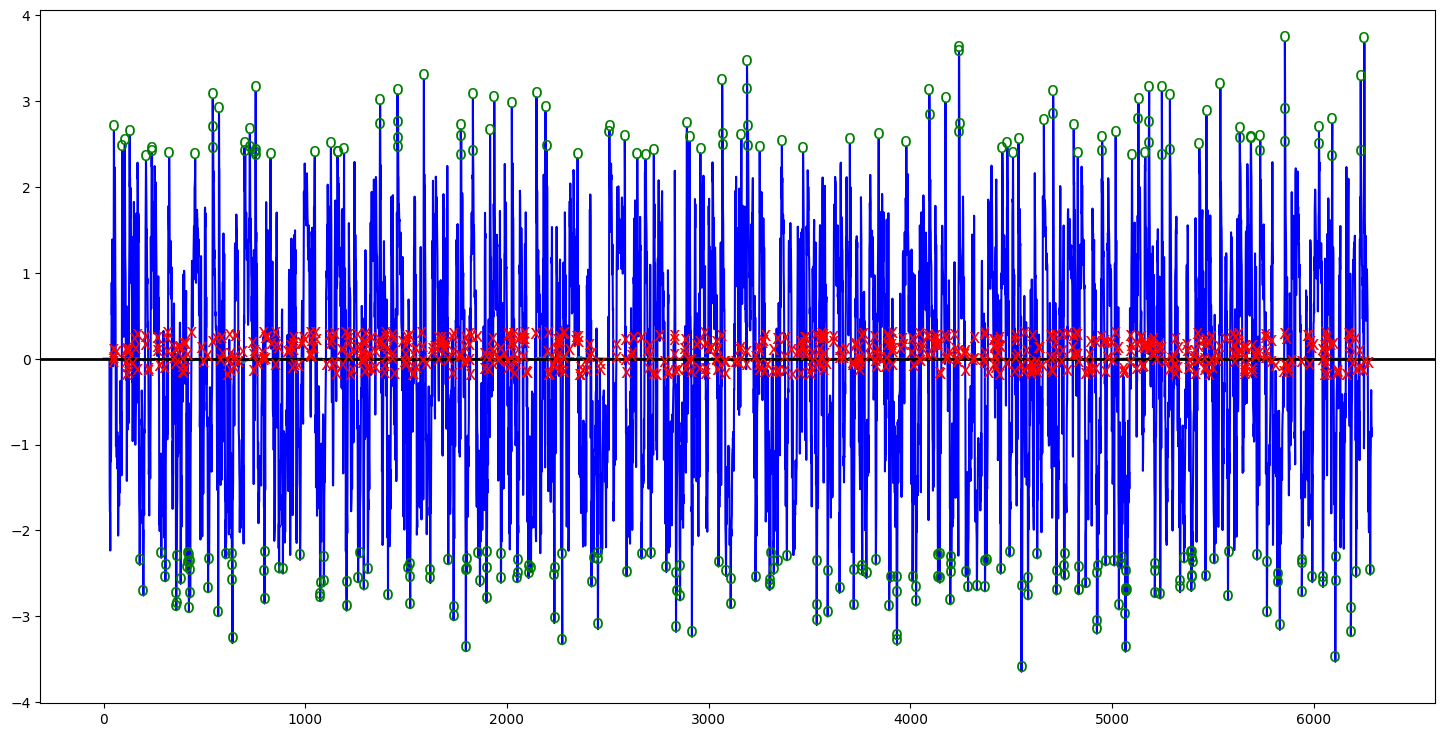

In [893]:
# 1. cutting points.
# 2. turning points.
dal_df['long_signal'] = False
dal_df['long_signal'] = (abs(dal_df["z"]) > 2.3) & (dal_df["ent"] > -0.1) #& (dal_df["Sih"] > -0.1) 
# Generate short (sell) signals
dal_df['short_signal'] = False
dal_df['short_signal'] = (abs(dal_df["z"]) < 0.25) & (abs(dal_df["z"]) > 0) & (dal_df["ent"] > -0.1) #& (dal_df["Sih"] > -0.1)                 #(dal_df["MA21D"] > 0.05) & (abs(dal_df["U"]) > 0) 

fig, ax = plt.subplots(figsize=(18, 9)) 

# Add arrows for long (buy) signals
long_signal_dates = dal_df[dal_df['long_signal']].indexl
for date in long_signal_dates:
    ax.annotate('o', xy=(date, dal_df.loc[date, 'z']), color='green', fontsize=14, ha='center')

# Add arrows for short (sell) signals
short_signal_dates = dal_df[dal_df['short_signal']].index
for date in short_signal_dates:
    ax.annotate('x', xy=(date, dal_df.loc[date, 'z']), color='red', fontsize=14, ha='center')

plt.plot(dal_df["z"], color = "blue")
#plt.plot(dal_df.MA21D*10, color="orange")
#plt.plot(dal_df["U"], color = "purple")
plt.plot(dal_df["ent"])
#plt.plot(dal_df["Sih"])
#plt.plot(dal_df["Sih2"]*2)

#plt.axhline(y=2.3 ,color = "red", linestyle="-", linewidth = 2)
#plt.axhline(y=0.1 ,color = "orange", linestyle="-", linewidth = 2)
plt.axhline(y=0 ,color = "black", linestyle="-", linewidth = 2)
#plt.axhline(y=-0.1 ,color = "orange", linestyle="-", linewidth = 2)
#plt.axhline(y=-2.3 ,color = "red", linestyle="-", linewidth = 2)

#plt.axvline(x=2303 ,color = "green", linestyle="-", linewidth = 1)
#plt.axvline(x=2410 ,color = "green", linestyle="-", linewidth = 1)
#plt.axvline(x=2432 ,color = "green", linestyle="-", linewidth = 1)
#plt.axvline(x=2450 ,color = "red", linestyle="-", linewidth = 1)
#plt.axvline(x=2473 ,color = "red", linestyle="-", linewidth = 1)

#plt.xlim(2200,2600)
#plt.ylim(-0.2,0.2)
plt.show()

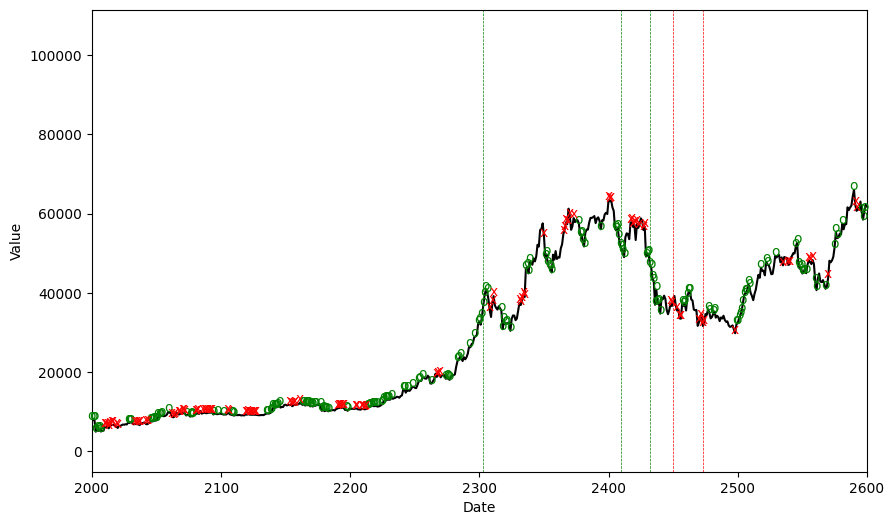

In [810]:
dal_df['long_signal'] = False
dal_df['long_signal'] = (abs(dal_df["z"]) > 1.5) #& (dal_df["MA6D"] < 0) & (abs(dal_df["U"]) > 0) 
# Generate short (sell) signals
dal_df['short_signal'] = False
dal_df['short_signal'] = (abs(dal_df["z"]) < 0.5) #& (dal_df["MA6D"] > 0) & (abs(dal_df["U"]) > 0) #(abs(dal_df["DPvol"]) < 0.2) 

fig, ax = plt.subplots(figsize=(10, 6))

# Add arrows for long (buy) signals
long_signal_dates = dal_df[dal_df['long_signal']].index
for date in long_signal_dates:
    ax.annotate('o', xy=(date, dal_df.loc[date, 'Close']), color='green', fontsize=10, ha='center')

# Add arrows for short (sell) signals
short_signal_dates = dal_df[dal_df['short_signal']].index
for date in short_signal_dates:
    ax.annotate('x', xy=(date, dal_df.loc[date, 'Close']), color='red', fontsize=10, ha='center')

# Plot the time series
plt.plot(dal_df.Close, color = "Black")
plt.xlabel('Date')
plt.ylabel('Value')
plt.xlim(2000,2600)

plt.axvline(x=2303 ,color = "green", linestyle="--", linewidth = 0.5)
plt.axvline(x=2410 ,color = "green", linestyle="--", linewidth = 0.5)
plt.axvline(x=2432 ,color = "green", linestyle="--", linewidth = 0.5)
plt.axvline(x=2450 ,color = "red", linestyle="--", linewidth = 0.5)
plt.axvline(x=2473 ,color = "red", linestyle="--", linewidth = 0.5)
#plt.ylim(10,35)
plt.show()

(2200.0, 2600.0)

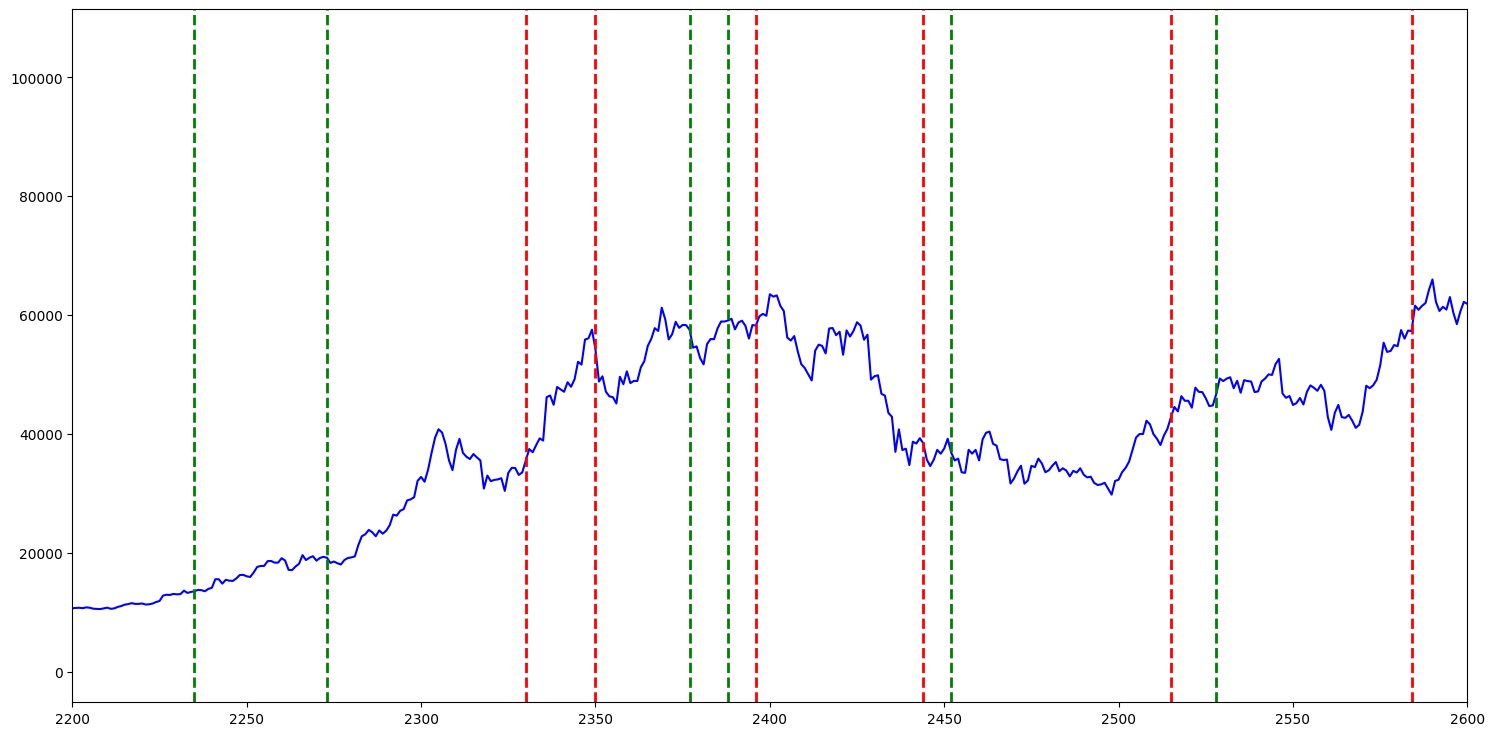

In [698]:
# 1. cutting points.
# 2. turning points.
plt.figure(figsize=(18, 9)) 

plt.plot(dal_df.Close, color = "blue")
plt.axvline(x=2235 ,color = "green", linestyle="--", linewidth = 2)
plt.axvline(x=2273 ,color = "green", linestyle="--", linewidth = 2)

plt.axvline(x=2330 ,color = "red", linestyle="--", linewidth = 2)
plt.axvline(x=2350 ,color = "red", linestyle="--", linewidth = 2)


plt.axvline(x=2377 ,color = "green", linestyle="--", linewidth = 2)
plt.axvline(x=2388 ,color = "green", linestyle="--", linewidth = 2)
plt.axvline(x=2396 ,color = "red", linestyle="--", linewidth = 2)
plt.axvline(x=2444 ,color = "red", linestyle="--", linewidth = 2)

plt.axvline(x=2452 ,color = "green", linestyle="--", linewidth = 2)
plt.axvline(x=2515 ,color = "red", linestyle="--", linewidth = 2)

plt.axvline(x=2528 ,color = "green", linestyle="--", linewidth = 2)
plt.axvline(x=2584 ,color = "red", linestyle="--", linewidth = 2)
#plt.ylim(10,35)
plt.xlim(2200,2600)

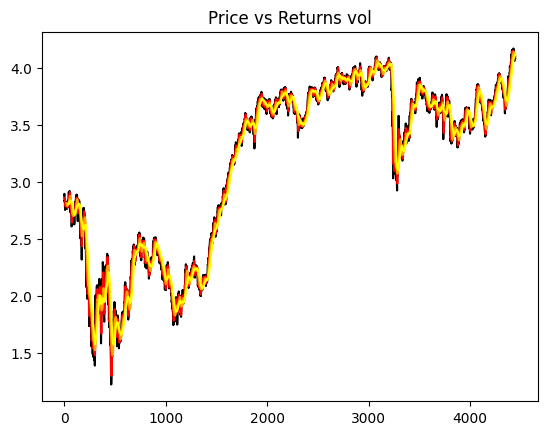

In [100]:
plt.plot(dal_df.log_p, color="black")
plt.plot(dal_df.MA6, color="red")
plt.plot(dal_df.MA21, color="orange")
plt.plot(dal_df.MA40, color="yellow")
plt.title("Price vs Returns vol")
#plt.xlim(800,1300)
#plt.ylim(1.7,3)
plt.show()

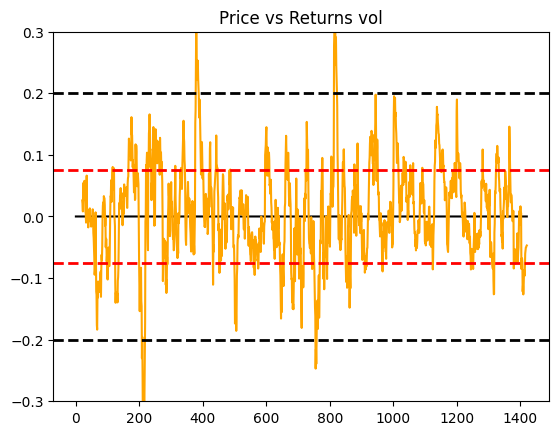

In [839]:
plt.plot(dal_df.log_p/dal_df.log_p - 1, color="black")
#plt.plot(dal_df.MA6D, color="red")
plt.plot(dal_df.MA21D, color="orange")
#plt.plot(dal_df.MA40D, color="yellow")
plt.title("Price vs Returns vol")
plt.axhline(y=0.2, color='black', linestyle='--', linewidth=2, label='Threshold')
plt.axhline(y=0.075, color='red', linestyle='--', linewidth=2, label='Threshold')
plt.axhline(y=-0.075, color='red', linestyle='--', linewidth=2, label='Threshold')
plt.axhline(y=-0.2, color='black', linestyle='--', linewidth=2, label='Threshold')


#plt.xlim(800,1300)
plt.ylim(-0.3,0.3)
plt.show()

In [894]:
import numpy as np
import pandas as pd

def run_strategy_and_sharpe(
    df: pd.DataFrame,
    price_col="Close",
    initial_cash=100.0,
    sell_fee=0.0005,
    base_scale=0.1,               # baseline fraction
    adjust_col="position_adjust",  # your vol-based sizing multiplier
    adj_min=0.0,                   # allow 0 (no trade)
    adj_max=2.0,                   # cap leverage of scaling
    periods_per_year=252,
    rf_annual=0.05
):
    cash = float(initial_cash)
    units = 0.0
    equity = np.empty(len(df), dtype=float)

    for i in range(len(df)):
        price = float(df[price_col].iloc[i])
        long_sig  = bool(df["long_signal"].iloc[i])
        short_sig = bool(df["short_signal"].iloc[i])

        # read sizing multiplier for this bar
        adj_raw = df[adjust_col].iloc[i] if adjust_col in df.columns else 1.0
        adj = float(adj_raw) if pd.notna(adj_raw) else 1.0
        adj = float(np.clip(adj, adj_min, adj_max))

        # dynamic trade fraction this bar
        scale = base_scale * adj
        scale = float(np.clip(scale, 0.0, 1.0))  # never spend > 100% of cash per buy

        if long_sig and cash > 0 and scale > 0:
            buy_cash = cash * scale
            units += buy_cash / price
            cash  -= buy_cash

        elif short_sig and units > 0 and scale > 0:
            sell_units = units * scale
            proceeds = sell_units * price * (1 - sell_fee)
            units -= sell_units
            cash  += proceeds

        equity[i] = cash + units * price

    equity_s = pd.Series(equity, index=df.index, name="equity")
    rets = equity_s.pct_change().fillna(0.0)

    rf_daily = (1.0 + rf_annual) ** (1.0 / periods_per_year) - 1.0
    excess = rets - rf_daily

    vol_excess = excess.std(ddof=1)
    sharpe = np.nan if vol_excess == 0 else (excess.mean() / vol_excess) * np.sqrt(periods_per_year)

    return {
        "equity": equity_s,
        "returns": rets,
        "sharpe": sharpe,
        "final_equity": float(equity_s.iloc[-1]),
        "final_cash": float(cash),
        "final_units": float(units),
    }



# ---- usage ----
result = run_strategy_and_sharpe(dal_df, periods_per_year=252)
print("Final equity:", result["final_equity"])
print("Sharpe:", result["sharpe"])


Final equity: 290.8751815170243
Sharpe: 0.021133033886524034


In [889]:
np.std(result["equity"])

145.28569615427216

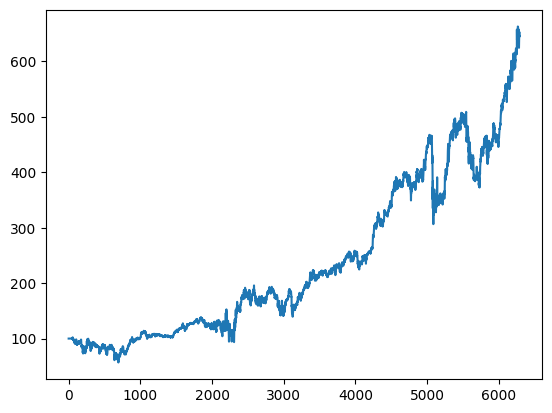

In [890]:
plt.plot(result["equity"])

In [891]:
V0 = 100
VT = 645
days = 6421
ppy = 252

cagr = (VT / V0) ** (ppy / days) - 1
cagr

0.07590062886417193

In [864]:
len(dal_df)

1421

## BTC

In [226]:
btc_df["log_p"] = np.log(btc_df["Close"])
btc_df["Returns"] = (btc_df['Close'] / btc_df['Close'].shift(1)) - 1

# Moving averages
btc_df['MA6'] = btc_df['log_p'].rolling(window=6).mean()
btc_df['MA21'] = btc_df['log_p'].rolling(window=21).mean()
btc_df['MA40'] = btc_df['log_p'].rolling(window=40).mean()

# Moving averages
btc_df['MA6D'] = np.exp(btc_df["log_p"] - btc_df["MA6"]) - 1
btc_df['MA21D'] = np.exp(btc_df["log_p"] - btc_df["MA21"]) - 1
btc_df['MA40D'] = np.exp(btc_df["log_p"] - btc_df["MA40"]) - 1

# Potential energy
btc_df["m"] = btc_df["log_p"].ewm(span=21, adjust=False).mean()
btc_df["s"] = btc_df['log_p'].ewm(span=21, adjust=False).std()
btc_df["U"] = (btc_df["log_p"] - btc_df["m"]) / (btc_df["s"])

#Intraday range
tr = [0]
for i in range(1,len(btc_df)):
    tr1 = (btc_df.High.iloc[i] - btc_df.Low.iloc[i]) / btc_df.Low.iloc[i] 
    tr2 = abs(btc_df.High.iloc[i] - btc_df.Close.iloc[i-1]) / btc_df.Close.iloc[i-1]
    tr3 = abs(btc_df.Low.iloc[i] - btc_df.Close.iloc[i-1]) / btc_df.Close.iloc[i-1]

    
    tr.append(max(tr1,tr2,tr3))

btc_df["TR"] = tr
btc_df["ATR"] = btc_df["TR"].rolling(window=21).mean()
btc_df["DATR"] = (btc_df['ATR'] / btc_df['ATR'].shift(1)) - 1
btc_df["D2ATR"] = btc_df["DATR"].rolling(window=21).mean()

#weighing process bayesian model average, regime conditioned weighting
#btc_df["ensemble"] = 1/10 * btc_df["Sih"] + 1/10 * btc_df["Sih2"] + ...

btc_df = btc_df.reset_index(drop = True)

In [259]:
import numpy as np

def _clean_xy(v, a):
    v = np.asarray(v, dtype=float)
    a = np.asarray(a, dtype=float)
    m = np.isfinite(v) & np.isfinite(a)
    return v[m], a[m]

def fit_linear_drag(v, a):
    """
    Fit a = g - k v
    Returns (g_hat, k_hat, diagnostics)
    """
    v, a = _clean_xy(v, a)
    # a = [1, -v] @ [g, k]
    X = np.column_stack([np.ones_like(v), -v])
    beta, *_ = np.linalg.lstsq(X, a, rcond=None)
    g_hat, k_hat = beta

    a_hat = X @ beta
    resid = a - a_hat
    diagnostics = {
        "rmse": float(np.sqrt(np.mean(resid**2))),
        "n": int(len(a)),
    }
    return float(g_hat), float(k_hat), diagnostics

def fit_quadratic_drag(v, a):
    """
    Fit a = g - c v|v|
    Returns (g_hat, c_hat, diagnostics)
    """
    v, a = _clean_xy(v, a)
    x = v * np.abs(v)  # v|v|
    # a = [1, -x] @ [g, c]
    X = np.column_stack([np.ones_like(x), -x])
    beta, *_ = np.linalg.lstsq(X, a, rcond=None)
    g_hat, c_hat = beta

    a_hat = X @ beta
    resid = a - a_hat
    diagnostics = {
        "rmse": float(np.sqrt(np.mean(resid**2))),
        "n": int(len(a)),
    }
    return float(g_hat), float(c_hat), diagnostics

def residuals_linear(v, a, g, k):
    v = np.asarray(v, float); a = np.asarray(a, float)
    a_model = g - k * v
    return a - a_model

def residuals_quadratic(v, a, g, c):
    v = np.asarray(v, float); a = np.asarray(a, float)
    a_model = g - c * v * np.abs(v)
    return a - a_model


In [346]:
btc_df["log_p"] = np.log(btc_df["Close"])
linreg = [0]
loglinreg = [0]
for i in range(1, len(btc_df)):
    lr = rolling_linreg_slope(btc_df["Close"][0:i], window = i - 1)[i-1]
    linreg.append(lr)
    llr = rolling_linreg_slope(btc_df["log_p"][0:i], window = i - 1)[i-1]
    loglinreg.append(llr)

linreg = linreg[10:]
loglinreg = loglinreg[10:]

C:\Users\Mark Brezina\AppData\Local\Temp\ipykernel_15924\2488586639.py:9: RuntimeWarning: Mean of empty slice.
  x_mean = x.mean()
C:\Users\Mark Brezina\anaconda3\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Mark Brezina\AppData\Local\Temp\ipykernel_15924\2488586639.py:14: RuntimeWarning: Mean of empty slice.
  y_demean = y_window - y_window.mean()
C:\Users\Mark Brezina\AppData\Local\Temp\ipykernel_15924\2488586639.py:9: RuntimeWarning: Mean of empty slice.
  x_mean = x.mean()
C:\Users\Mark Brezina\anaconda3\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Mark Brezina\AppData\Local\Temp\ipykernel_15924\2488586639.py:14: RuntimeWarning: Mean of empty slice.
  y_demean = y_window - y_window.mean()


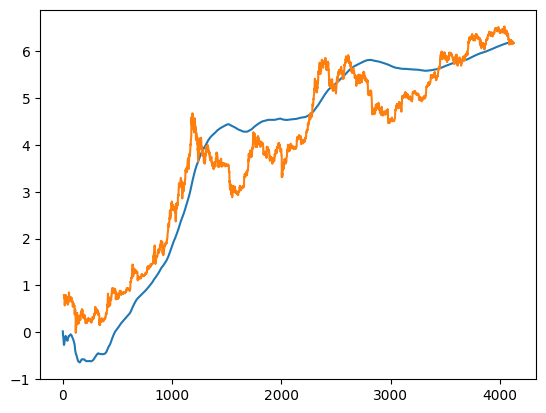

In [362]:
plt.plot(loglinreg*btc_df.index[10:])
plt.plot(btc_df.log_p[10:]-5.2)

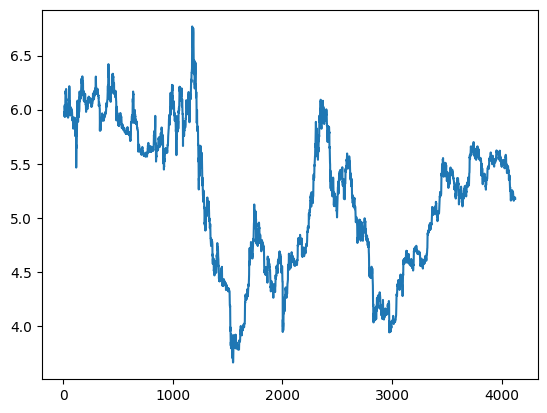

In [354]:
plt.plot(btc_df.log_p[10:] - loglinreg*btc_df.index[10:])
#plt.
#plt.plot(btc_df.Close[10:] - linreg*btc_df.index[10:])

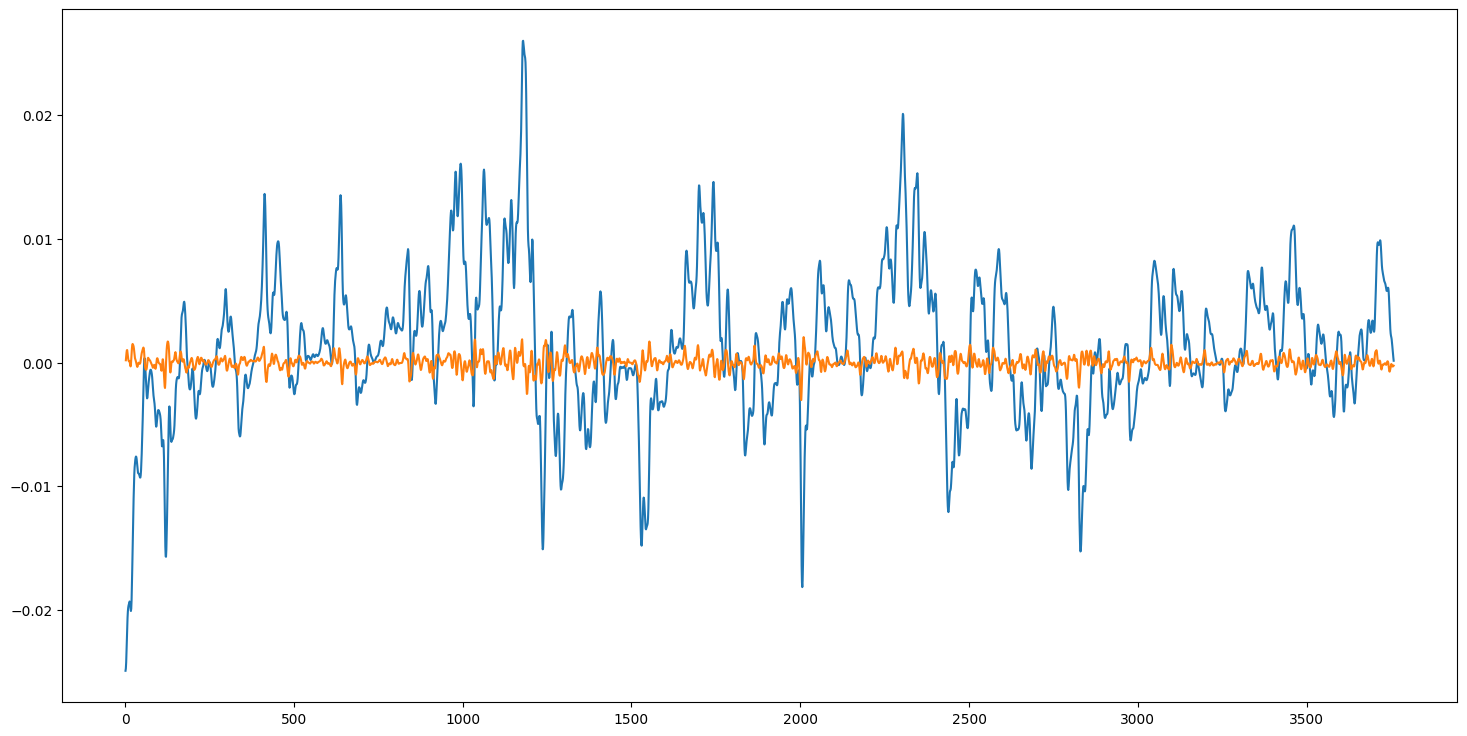

In [282]:
import numpy as np
from scipy.interpolate import make_smoothing_spline
import matplotlib.pyplot as plt
x = btc_df.index
rng = np.random.default_rng()
y =  btc_df.log_p


spl = make_smoothing_spline(x, y, lam=10) # lambda = None and lambda 10
btc_df["smooth_logp"] = spl(x)  # smoothed log price

# velocity (log-return-like, per bar)
btc_df["v"] = btc_df["smooth_logp"].diff()

# acceleration (second difference)
btc_df["a"] = btc_df["smooth_logp"].diff().diff()
# or: btc_df["a"] = btc_df["smooth_logp"].diff(2)

btc_df["v20"] = btc_df["smooth_logp"].diff(20) / 20
btc_df["a20"] = btc_df["v20"].diff(20) / 20

btc_df["a_rel"] = btc_df["v"].pct_change(20)  # same idea, but still can spike
v = btc_df["v"].ewm(span=50, adjust=False).mean()
a = v.diff()  # or diff(20)

# optional: smooth acceleration as well
#a = a.ewm(span=50, adjust=False).mean()




plt.figure(figsize=(18, 9)) 
#plt.plot(btc_df["Returns"])
plt.plot(v)
plt.plot(a)
#plt.xlim(2180,2200)
#plt.ylim(-1,1)

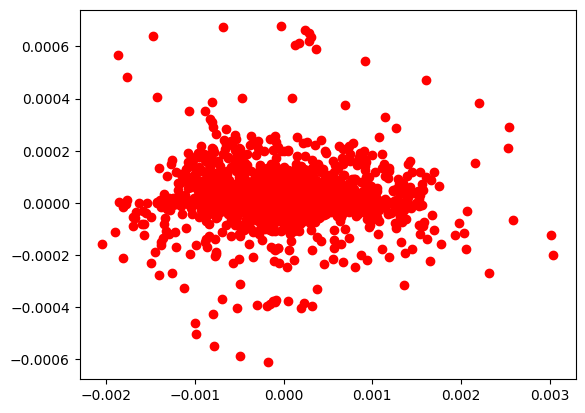

In [290]:
plt.plot(5.91e-06-a,v*abs(v), "ro")

In [283]:
g1, k, d1 = fit_linear_drag(v, a)
g2, c, d2 = fit_quadratic_drag(v, a)

print("Linear:", g1, k, d1)
print("Quadratic:", g2, c, d2)
# g is approximately -0.0381 or -0.0404

Linear: 4.912250516496121e-06 -0.0013856476842227874 {'rmse': 0.0005241800075677097, 'n': 3757}
Quadratic: 5.900219394334243e-06 -0.06557529474540745 {'rmse': 0.0005242179647796278, 'n': 3757}


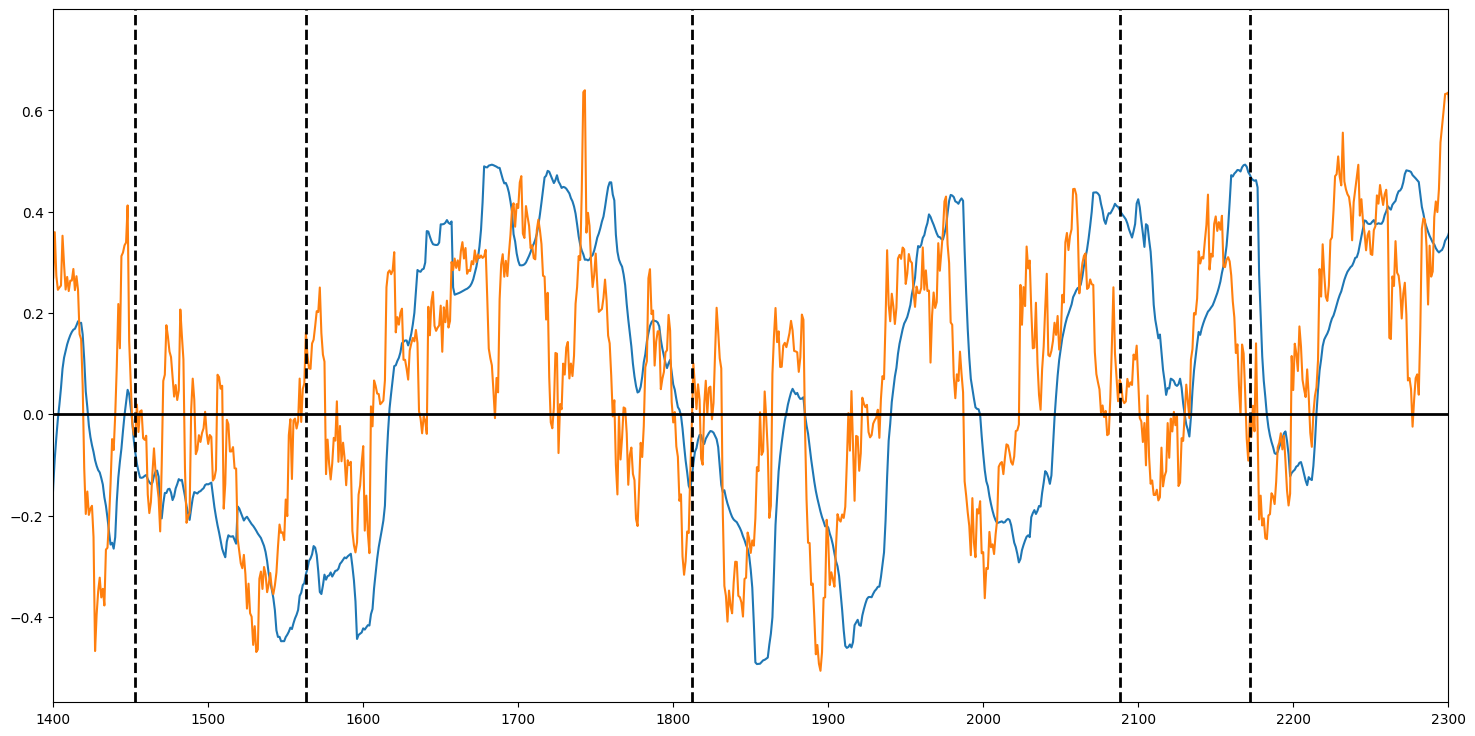

In [230]:
#trend strength
btc_df["TS"] = (btc_df["log_p"].ewm(span=21, adjust=False).mean() - btc_df["log_p"].ewm(span=40, adjust=False).mean()) / btc_df["log_p"].rolling(window=21).std()



btc_df["TSM"] = btc_df["log_p"] / btc_df["log_p"].shift(21) - 1
btc_df['Momentum'] = btc_df["Returns"].rolling(window=21).mean()
btc_df['TSMom'] = btc_df['Returns'].rolling(window=21).mean() / btc_df["Returns"].rolling(window=21).std()
btc_df["Sih"] = np.tanh(btc_df["TS"])
btc_df["Sih2"] = np.tanh(btc_df["TSMom"])

#plt.plot(btc_df["udvr"])
plt.figure(figsize=(18, 9)) 
#plt.plot(btc_df["TSMom"]/10)
#plt.plot(btc_df["TSM"])

plt.plot(btc_df["Sih"]/2)
plt.plot(btc_df["Sih2"])


plt.axhline(y=0, color='black', linestyle='-', linewidth=2, label='Threshold')

plt.axvline(x=1453 ,color = "black", linestyle="--", linewidth = 2)
#plt.axvline(x=1513 ,color = "black", linestyle="--", linewidth = 2)
plt.axvline(x=1563 ,color = "black", linestyle="--", linewidth = 2)
#plt.axvline(x=1610 ,color = "black", linestyle="--", linewidth = 2)
#plt.axvline(x=1650 ,color = "black", linestyle="--", linewidth = 2)
plt.axvline(x=1812 ,color = "black", linestyle="--", linewidth = 2)
#plt.axvline(x=1832 ,color = "black", linestyle="--", linewidth = 2)
plt.axvline(x=2088 ,color = "black", linestyle="--", linewidth = 2)
#plt.axvline(x=2138 ,color = "black", linestyle="--", linewidth = 2)
plt.axvline(x=2172 ,color = "black", linestyle="--", linewidth = 2)
#plt.axvline(x=2222 ,color = "black", linestyle="--", linewidth = 2)

plt.xlim(1400,2300)
#plt.ylim(-0.1,0.1)
plt.show()

In [232]:
#Close location value
hl = (btc_df["High"] - btc_df["Low"]).replace(0, np.nan)
btc_df["clv"] = (2*btc_df["Close"] - btc_df["High"] - btc_df["Low"]) / hl

# Chaikin money flow
btc_df["cmf"] = (btc_df["clv"] * btc_df["Volume"]).rolling(window=21).sum() / btc_df["Volume"].rolling(window=21).sum()

# accumulative/distribution line
btc_df["mfv"] = btc_df["clv"] * btc_df["Volume"]         # money flow volume
btc_df["adl"] = btc_df["mfv"].fillna(0).cumsum()

# up/down volume ratio
up_vol = btc_df["Volume"].where(btc_df["Close"].diff() > 0, 0.0)
dn_vol = btc_df["Volume"].where(btc_df["Close"].diff() < 0, 0.0)
btc_df["udvr"] = up_vol.rolling(window=21).sum() / (dn_vol.rolling(window=21).sum() + 1e-12)
btc_df["udvi"] = (up_vol.rolling(window=21).sum() - dn_vol.rolling(window=21).sum()) / (btc_df["Volume"].rolling(window=21).sum() + 1e-12)

#VWAP pressure
tp = (btc_df["High"] + btc_df["Low"] + btc_df["Close"]) / 3
btc_df["tp_vwap_like"] = (tp * btc_df["Volume"]).rolling(window=21).sum() / btc_df["Volume"].rolling(window=21).sum()
btc_df["vwap_dev"] = np.log(btc_df["Close"]) - np.log(btc_df["tp_vwap_like"])


In [135]:
print(sum(btc_df["udvi"][1453:1513]))
print(sum(btc_df["udvi"][1563:1650]))
print(sum(btc_df["udvi"][1812:1832]))
print(sum(btc_df["udvi"][2088:2138]))
print(sum(btc_df["udvi"][2172:2222]))

print("test:",sum(btc_df["udvi"][1513:1520]))

-1.4873472885632009
10.324643465464556
-3.356466411034933
-1.672711010752866
6.00319017960409
test: 1.018131037633038


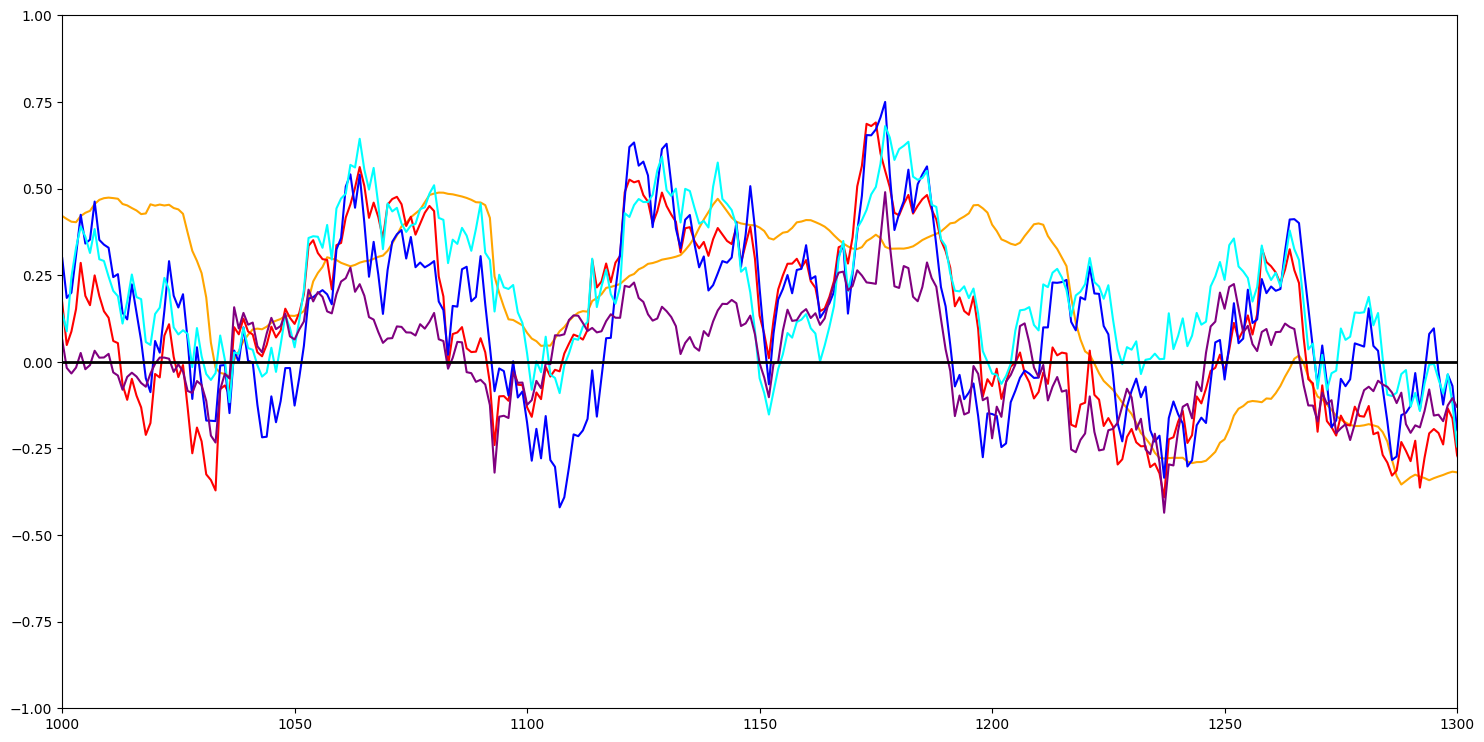

In [241]:
#plt.plot(btc_df["udvr"])
plt.figure(figsize=(18, 9)) 
plt.plot(btc_df["Sih"]/2, color = "orange")
plt.plot(btc_df["Sih2"], color = "red")

plt.plot(btc_df["udvi"] /  max(btc_df["udvi"][20:]), color = "blue")
#plt.plot(btc_df["adl"]/1000000000000) # dip between 1550 and 1600 - looks like multiple logistic function repeating over all time
plt.plot(btc_df["cmf"]/max(btc_df["cmf"][20:]), color = "cyan")
plt.plot(btc_df["vwap_dev"], color = "purple")
plt.axhline(y=0, color='black', linestyle='-', linewidth=2, label='Threshold')

plt.axvline(x=1453 ,color = "black", linestyle="--", linewidth = 2)
#plt.axvline(x=1513 ,color = "black", linestyle="--", linewidth = 2)
plt.axvline(x=1563 ,color = "black", linestyle="--", linewidth = 2)
#plt.axvline(x=1610 ,color = "black", linestyle="--", linewidth = 2)
#plt.axvline(x=1650 ,color = "black", linestyle="--", linewidth = 2)
plt.axvline(x=1812 ,color = "black", linestyle="--", linewidth = 2)
#plt.axvline(x=1832 ,color = "black", linestyle="--", linewidth = 2)
plt.axvline(x=2088 ,color = "black", linestyle="--", linewidth = 2)
#plt.axvline(x=2138 ,color = "black", linestyle="--", linewidth = 2)
plt.axvline(x=2172 ,color = "black", linestyle="--", linewidth = 2)
#plt.axvline(x=2222 ,color = "black", linestyle="--", linewidth = 2)

plt.xlim(1000,1300)
plt.ylim(-1,1)
plt.show()

In [8]:
btc_df["theta"] = -rolling_linreg_slope(y = btc_df["MA21D"].shift(1), window = 21)
btc_df["Kin"] = 1/2 * (btc_df['log_p'] - btc_df['log_p'].shift(1))**2
btc_df["Pot"] = 1/8 * (btc_df['log_p'] - btc_df['MA21'])**2
btc_df["lagrangian"] = btc_df["Kin"] - btc_df["Pot"]
btc_df["ent"] = btc_df["lagrangian"].rolling(window=21).sum()

In [ ]:
euler lagrange equation

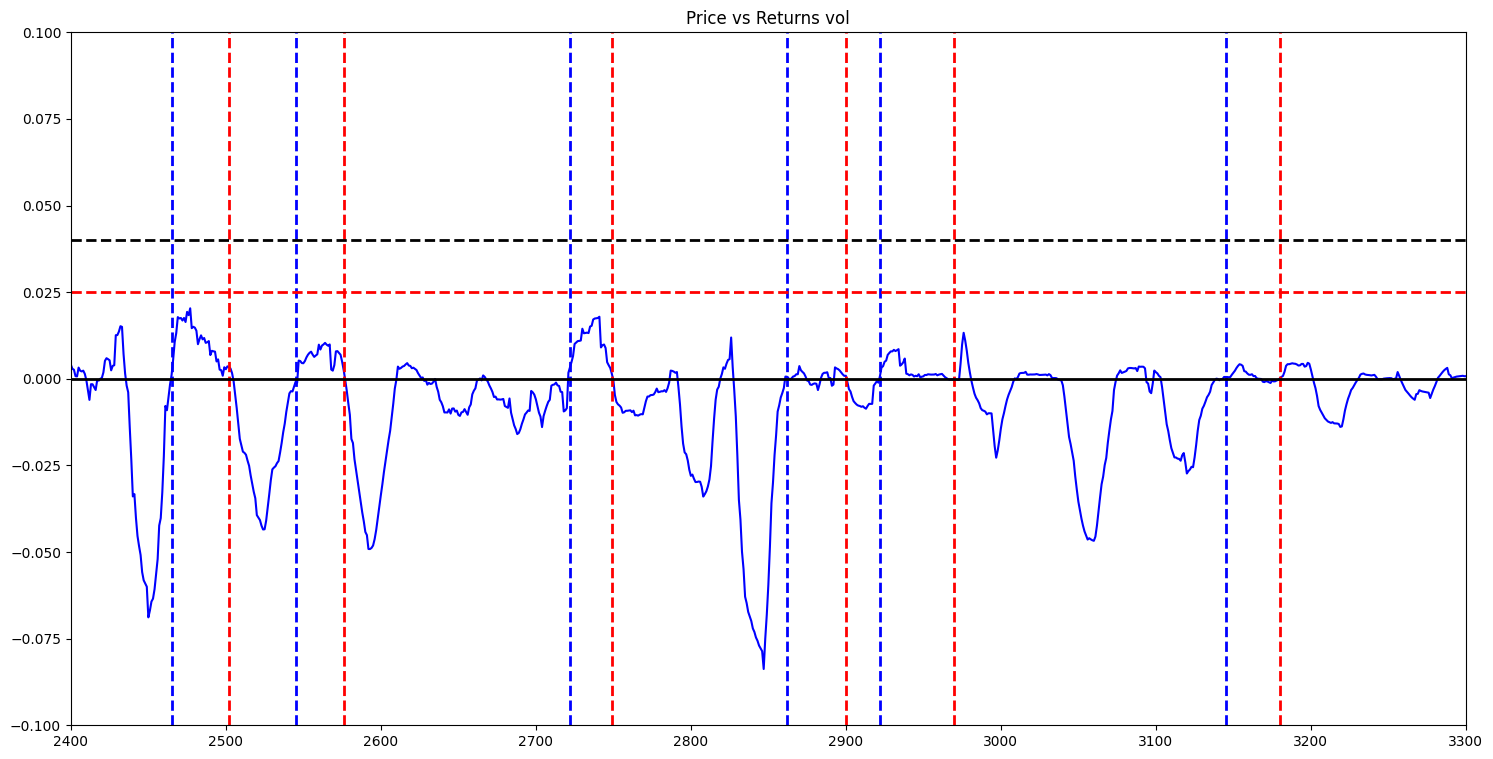

In [202]:
plt.figure(figsize=(18, 9)) 
#plt.plot(abs(btc_df.ATR), color="black")
#plt.plot(abs(btc_df.D2ATR), color="red",alpha = 1)
#plt.plot(btc_df.Kin, color="blue")
#plt.plot(btc_df.Pot, color="red")
plt.plot(btc_df.ent, color="blue")
plt.axvline(x=1453 ,color = "blue", linestyle="--", linewidth = 2)
plt.axvline(x=1513 ,color = "red", linestyle="--", linewidth = 2)
plt.axvline(x=1563 ,color = "blue", linestyle="--", linewidth = 2)
#plt.axvline(x=1610 ,color = "black", linestyle="--", linewidth = 2)
plt.axvline(x=1650 ,color = "red", linestyle="--", linewidth = 2)
plt.axvline(x=1812 ,color = "blue", linestyle="--", linewidth = 2)
plt.axvline(x=1832 ,color = "red", linestyle="--", linewidth = 2)
plt.axvline(x=2088 ,color = "blue", linestyle="--", linewidth = 2)
plt.axvline(x=2138 ,color = "red", linestyle="--", linewidth = 2)
plt.axvline(x=2172 ,color = "blue", linestyle="--", linewidth = 2)
plt.axvline(x=2222 ,color = "red", linestyle="--", linewidth = 2)

#positive energy test
plt.axvline(x=2465 ,color = "blue", linestyle="--", linewidth = 2)
plt.axvline(x=2502 ,color = "red", linestyle="--", linewidth = 2)
plt.axvline(x=2545 ,color = "blue", linestyle="--", linewidth = 2)
plt.axvline(x=2576 ,color = "red", linestyle="--", linewidth = 2)
plt.axvline(x=2722 ,color = "blue", linestyle="--", linewidth = 2)
plt.axvline(x=2749 ,color = "red", linestyle="--", linewidth = 2)


plt.axvline(x=2862 ,color = "blue", linestyle="--", linewidth = 2)
plt.axvline(x=2900 ,color = "red", linestyle="--", linewidth = 2)
plt.axvline(x=2922 ,color = "blue", linestyle="--", linewidth = 2)
plt.axvline(x=2970 ,color = "red", linestyle="--", linewidth = 2)
plt.axvline(x=3145 ,color = "blue", linestyle="--", linewidth = 2)
plt.axvline(x=3180 ,color = "red", linestyle="--", linewidth = 2)


plt.axhline(y=0.04, color='black', linestyle='--', linewidth=2, label='Threshold')
plt.axhline(y=0.025, color='red', linestyle='--', linewidth=2, label='Threshold')
plt.axhline(y=0, color='black', linestyle='-', linewidth=2, label='Threshold')
#plt.axhline(y=-0.1, color='red', linestyle='--', linewidth=2, label='Threshold')
#plt.axhline(y=-0.18, color='black', linestyle='--', linewidth=2, label='Threshold')
plt.title("Price vs Returns vol")
plt.xlim(2400,3300)
plt.ylim(-0.1,0.1)
plt.show()

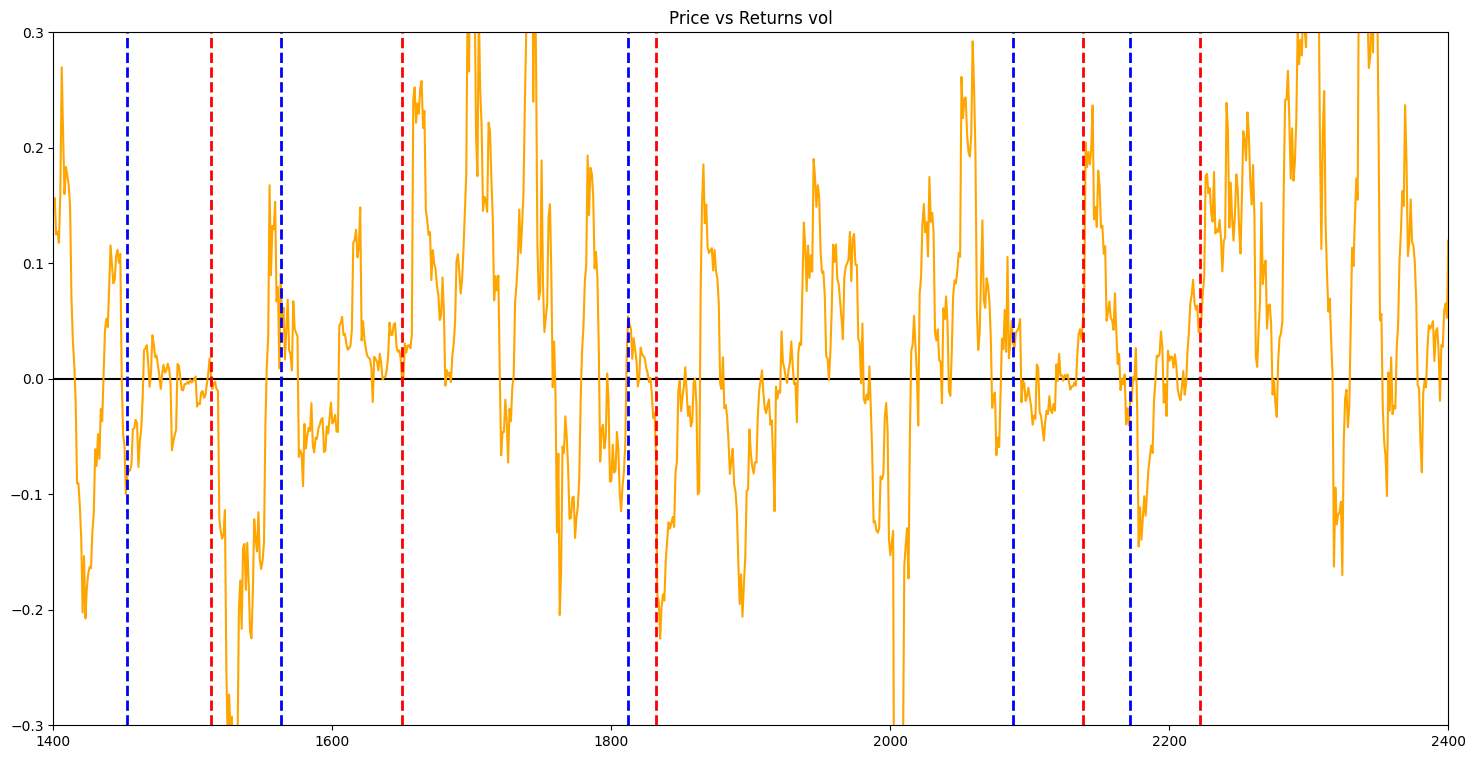

In [168]:
plt.figure(figsize=(18, 9)) 
plt.plot(btc_df.log_p/btc_df.log_p - 1, color="black")
#plt.plot(btc_df.MA6D / max(btc_df.MA6D[6:]), color="red")
plt.plot(btc_df.MA21D / max(btc_df.MA21D[20:]), color="orange") #sum = 0?
#plt.plot(btc_df.MA40D/ max(btc_df.MA40D[40:]), color="yellow")
#plt.plot(btc_df.U/10, color="blue") #sum = 0?
#plt.plot(-btc_df.ent, color="purple") #flat zones
plt.axvline(x=1453 ,color = "blue", linestyle="--", linewidth = 2)
plt.axvline(x=1513 ,color = "red", linestyle="--", linewidth = 2)
plt.axvline(x=1563 ,color = "blue", linestyle="--", linewidth = 2)
#plt.axvline(x=1610 ,color = "black", linestyle="--", linewidth = 2)
plt.axvline(x=1650 ,color = "red", linestyle="--", linewidth = 2)
plt.axvline(x=1812 ,color = "blue", linestyle="--", linewidth = 2)
plt.axvline(x=1832 ,color = "red", linestyle="--", linewidth = 2)
plt.axvline(x=2088 ,color = "blue", linestyle="--", linewidth = 2)
plt.axvline(x=2138 ,color = "red", linestyle="--", linewidth = 2)
plt.axvline(x=2172 ,color = "blue", linestyle="--", linewidth = 2)
plt.axvline(x=2222 ,color = "red", linestyle="--", linewidth = 2)
plt.title("Price vs Returns vol")
plt.xlim(1400,2400)
plt.ylim(-0.3,0.3)
plt.show()

In [ ]:
plt.axvline(x=2862 ,color = "blue", linestyle="--", linewidth = 2)
plt.axvline(x=2900 ,color = "red", linestyle="--", linewidth = 2)
plt.axvline(x=2922 ,color = "blue", linestyle="--", linewidth = 2)
plt.axvline(x=2980 ,color = "red", linestyle="--", linewidth = 2)
plt.axvline(x=3145 ,color = "blue", linestyle="--", linewidth = 2)
plt.axvline(x=3200 ,color = "red", linestyle="--", linewidth = 2)

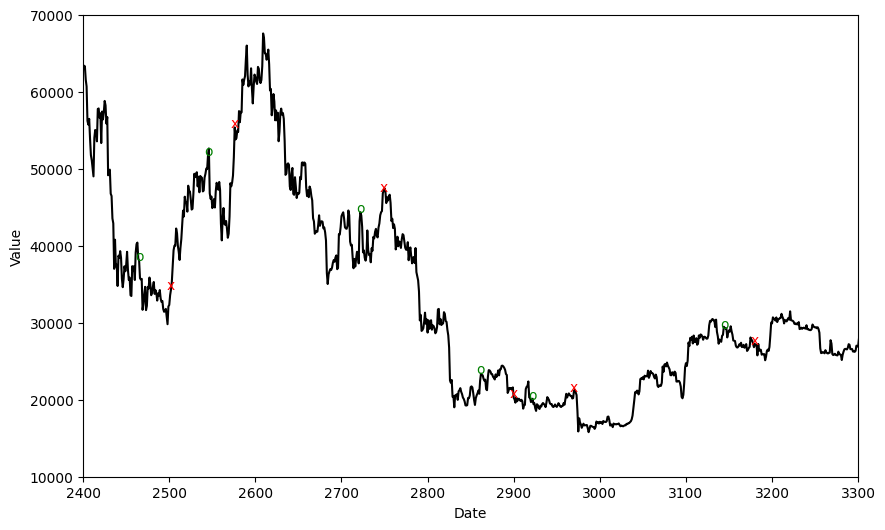

In [203]:
btc_df['long_signal'] = btc_df.index.isin([1453,1563,1812,2088,2172,2465,2545,2722,2862,2922,3145]) #blues
# Generate short (sell) signals
btc_df['short_signal'] = btc_df.index.isin([1513,1650,1832,2138,2222,2502,2576,2749,2900,2970,3180]) #reds

fig, ax = plt.subplots(figsize=(10, 6))

# Add arrows for long (buy) signals
long_signal_dates = btc_df[btc_df['long_signal']].index
for date in long_signal_dates:
    ax.annotate('o', xy=(date, btc_df.loc[date, 'Close']), color='green', fontsize=10, ha='center')

# Add arrows for short (sell) signals
short_signal_dates = btc_df[btc_df['short_signal']].index
for date in short_signal_dates:
    ax.annotate('x', xy=(date, btc_df.loc[date, 'Close']), color='red', fontsize=10, ha='center')

# Plot the time series
plt.plot(btc_df.Close, color = "Black")
plt.xlabel('Date')
plt.ylabel('Value')
plt.xlim(2400,3300)
plt.ylim(10000,70000)
plt.show()

In [232]:
import numpy as np
import pandas as pd

def run_strategy_and_sharpe(
    df: pd.DataFrame,
    price_col="Close",
    vol_col="daily_vol",
    z_col="z",
    initial_cash=100.0,
    sell_fee=0.005,         # 0.5% fee on sells, as in your code
    periods_per_year=252,   # crypto trades daily; use 252 if your df is business days
    rf_annual=0.05           # set >0 if you want excess Sharpe vs risk-free
):
    cash = float(initial_cash)
    units = 0.0
    in_pos = False
    entry_price = np.nan
    equity = np.empty(len(df), dtype=float)

    for i in range(len(df)):
        price = float(df[price_col].iloc[i])

        if (not in_pos) and df["long_signal"][i] == True:
            units = cash / price   # <-- corrected
            cash = 0.0
            entry_price = price
            in_pos = True

        elif in_pos and df["short_signal"][i] == True:
            cash = units * price * (1 - sell_fee)
            units = 0.0
            in_pos = False


        equity[i] = cash + units * price

    equity_s = pd.Series(equity, index=df.index, name="equity")

    # daily simple returns
    rets = equity_s.pct_change().fillna(0.0)
    rets.name = "returns"

    # risk-free adjustment (optional)
    rf_daily = (1.0 + rf_annual) ** (1.0 / periods_per_year) - 1.0
    excess = rets - rf_daily

    # Sharpe
    vol_excess = excess.std(ddof=1)
    sharpe = np.nan if vol_excess == 0 else (excess.mean() / vol_excess) * np.sqrt(periods_per_year)

    return {
        "equity": equity_s,
        "returns": rets,
        "sharpe": sharpe,
        "final_equity": float(equity_s.iloc[-1]),
    }

# ---- usage ----
result = run_strategy_and_sharpe(btc_df, periods_per_year=252)
print("Final equity:", result["final_equity"])
print("Sharpe:", result["sharpe"])


Final equity: 1005.1718193364767
Sharpe: 0.46352467534479314


In [206]:
min(result["returns"])

-0.37169538560117066